In [891]:
# from sympy import *
# from sympy.geometry import *
# import sympy as sp
import numpy as np
from scipy.optimize import fsolve,root,brentq,minimize
from TCSPC import *
plt.rcParams['figure.constrained_layout.use'] = True

mono exp phasor = 
$$z(a,n) = \frac{1+i(na)}{1+(na)^2}$$
where $a = \omega \tau$, fundamental angular frequency $\omega = 2\pi T/ N$, $N$ is number of bins , $T$ is period (in ns) $n$ denotes $n^{\text{th}}$ harmonic ($\omega_n = n\omega$).

Under inversion $$T(z) := \left(\frac{1}{z-1}+1\right)^*$$
mono exp phasors become:
$$T(z(a)) = \frac{i}{a}$$

For given bi-exp phasors:
$$z (a_1,a_2) = f \cdot z(a_1) + (1-f)\cdot z(a_2) $$

In [303]:
EGFP = Phasor([0.497,0.503],[2.43,3.07])

In [440]:
p(1)

(0.5679816065500891+0.4920326600625657j)

### Numerical results

In [605]:
N = 19
tau =np.array([2.43,3.07] ) #lifetimes,ns
A = np.array([0.497,0.503]) #amplitudes
a1_true = EGFP.w[1]*tau[0] #mono exp phasor a
a2_true = EGFP.w[1]*tau[1]
f = A*tau/np.sum(A*tau)         #fractional intensity
mono = lambda n,a : (1+n*a*1j)/(1+(n*a)**2)
p_noise = 0.0001*np.random.randn(1, 2).view(np.complex128)[0][0]
p = lambda n : f[0] * mono(n,a1_true) + f[1]*mono(n,a2_true) + p_noise  #add gaussian noise
#p = lambda n : EGFP.phasor[n]

def inv(z):
    '''Perform inversion on a complex number z using circle of inversion at 1 with radius 1'''
    return np.conjugate(1/(z-1)+1)

# def y(x,n):
#     '''Calculates the inverted intercept y of harmonics n for given guess inverted phasor x and bi-exp phasor p
#        Using "angles of the same sgement", angle theta between x,p,1 (centre of inversion circle) and x,y,1 are the same
#        y = tan(theta-pi/2)'''
#     theta = np.angle((x/n*1j-inv(p(n)))/(1-inv(p(n)))) #angle between x,p,1
#     return np.tan(theta-np.pi/2)

def y_intercept(z1,z3,z2= 1):
    '''y-intercept of circle defined by z1,z2,z3,
       z1 lies on y axis (inverted mono exp component)
       z2 = 1
       z3 is the inverted bi exp phasor
       if z1.imag >z3.imag, y-intercept is below z1, hence the np.sign is used
       circle of the form z = (a+bt)/(c+dt) where t is a parameter'''
    a = z2*(z1-z3)
    b = z1*(z2-z3)
    c = z1-z3
    d = z2-z3
    centre = (a*np.conjugate(d)-b*np.conjugate(c))/(c*np.conjugate(d)-d*np.conjugate(c))
    y_sol = z1.imag-2*(z1.imag-centre.imag)
    return y_sol

def y_intercept_slope(z1,z3,alpha):
    '''intercepts of circle with line of slope -cot(alpha), given circle defined by z1,z3,and z2 =1 '''
    #rotate the set up by alpha so the line becomes y intercept
    z2 = np.exp(-alpha*1j)
    z1 *=np.exp(-alpha*1j)
    z3 *=np.exp(-alpha*1j)
    y_sol = y_intercept(z1,z3,z2) #real value only (z4 = y_sol*1j)
    return  np.exp(alpha*1j)*y_sol*1j #rotate back


def y(x,n):
    '''Return y intercept for given x (guess inverted phasor) and harmonic n'''
    z1 = x*1j/n #inverted mono
    z3 = inv(p(n)) #bi-exp
    return y_intercept(z1,z3)

def x_eq(x):
    '''In general, intercepts of a line from guess phasor to given bi-exp phasor of 
       different harmonics and the universal circle may not be related by harmonics. 
       The goal is to find x (inverted mono exp phasor) such that the inverted intercept y are related by harmonics
       inverted phasors are related by nth harmonics: x_n = x/n. The absolute value is taken for minimization purpose
       '''
    return abs(y(x,1)/2-y(x,2))


z3 = inv(p(1))
z1 = 1.7j
z2 = 1


In [556]:
x_eq(1.05)

0.0027081734631786425

In [557]:
print('a1 inverted: ',1/a1_true)
print('a2 inverted: ', 1/a2_true)

a1 inverted:  1.3099172270937887
a2 inverted:  1.0368400201426407


In [579]:
result = minimize(x_eq,x0 = [1/a1_true+1], bounds = [(0,1000)]) #solve the equations with bounds
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.2256862191861728e-12
        x: [ 1.307e+00]
      nit: 6
      jac: [ 5.040e-02]
     nfev: 106
     njev: 53
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [580]:
a1_result = 1/result.x # convert back to real space
a2_result = 1/y(result.x,1) # convert back to real space
tau1_result = a1_result/EGFP.w[1]
tau2_result = a2_result/EGFP.w[1]
print(tau1_result)
print(tau2_result)

[2.43516122]
[3.08673992]


In [760]:
EGFP.n_photon = int(1e9)
EGFP.repeat_sim(100)

In [938]:
N = 380 #N histogram bins
alpha = 2*np.pi/N
mono_d = lambda x,n :(1-x)/(1-x*np.exp(1j*n*alpha)) #d for discrete
tau = [2.43,3.07]
z1 = lambda x, n : inv(mono_d(x,n)) #0.5 * (1-1/x)*(1-1j/np.tan(alpha*n/2))
z3 = lambda n :inv(EGFP.phasor_data[16][n])
x = lambda tau: np.exp(-1/19/tau)
p_d = lambda n : np.sum(A*np.array([mono_d(x(tau[0]),n),mono_d(x(tau[1]),n)])) #pure bi-exp discrete phasor
p_noise = np.random.normal(scale = 0.001,size = (1, 2)).view(np.complex128)[0][0]
z3 = lambda n :inv(p_d(n)+p_noise)
#z3 = lambda n : inv(p_d(n))
print(y_intercept_slope(z1(x(tau[0]),1),z3(1),alpha/2))
print(y_intercept_slope(z1(x(tau[0]),2),z3(2),alpha))
def discrete_eq(tau):
    return abs(y_intercept_slope(z1(x(tau),1),z3(1),alpha/2).real-y_intercept_slope(z1(x(tau),2),z3(2),alpha).real)
discrete_eq(tau[0])

(-0.008990949516016967+1.0875003072894807j)
(-0.009113455128043256+0.551121313938732j)


0.0001225056120262892

In [939]:
result_discrete = minimize(discrete_eq,x0 = [4], bounds = [(0,10)],method = 'cobyla')
result_discrete

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 2.631560906338204e-08
       x: [ 3.275e+00]
    nfev: 23
   maxcv: 0.0

In [940]:
-1/np.log(1/(1-y_intercept_slope(z1(x(result_discrete.x),1),z3(1),alpha/2).real*2))/19

array([2.60490689])

In [930]:
np.random.normal(scale = 0.001,size = (1, 2)).view(np.complex128)[0][0]

(-2.18847613609367e-05-0.0007525726889747615j)

In [884]:
EGFP.n_photon = int(1e3)
EGFP.repeat_sim(5000)
EGFP.phasor_solve_num()

 message: The solution converged.
 success: True
  status: 1
     fun: [ 1.110e-16 -5.551e-16 -1.665e-16]
       x: [ 4.975e-01  2.382e+00  3.125e+00]
  method: hybr
    nfev: 14
    fjac: [[-1.819e-07 -7.845e-01 -6.201e-01]
           [-1.164e-06 -6.201e-01  7.845e-01]
           [ 1.000e+00 -8.645e-07  8.002e-07]]
       r: [-1.646e-01  9.641e-02  1.220e-01 -9.696e-03  8.910e-03
            2.542e-08]
     qtf: [-6.975e-11 -2.218e-11  2.946e-16]

In [898]:
y_pure = exp2(EGFP.t,EGFP.amp[0],*EGFP.tau)
y_conv = np.convolve(y_pure,EGFP.ker,'full')[:380]
w,fft_pure = EGFP.phasor_fft(y_conv)
fft_pure[1]

(0.5733227893221606+0.48726799688720646j)

In [944]:
from scipy.stats import gaussian_kde

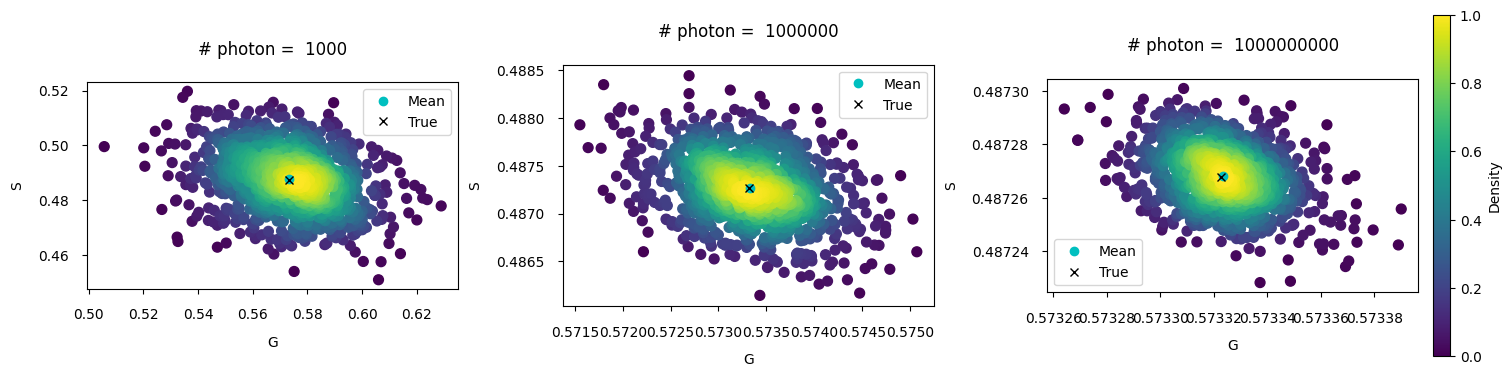

In [973]:
fig, ax = plt.subplots(1,3,figsize = (15,4))
n_harmonic= 1
fig.suptitle('')
for i in range(3):
    EGFP.n_photon = [int(1e3),int(1e6),int(1e9)][i]
    EGFP.repeat_sim(1000)   
    ax[i].set_title(f'# photon =  {EGFP.n_photon}',pad = 20 )
    mean = np.mean(EGFP.phasor_data[:,n_harmonic]) #mean of 1st harmonic, phasor_data
    x = EGFP.phasor_data[:,n_harmonic].real
    y = EGFP.phasor_data[:,n_harmonic].imag

    #calculate point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    z = (z - z.min()) / z.ptp() #scale z such that highest is 1, min. is 0
    #sort points by density
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    cax = ax[i].scatter(x, y, c=z, s=50,cmap = 'viridis')

    #cax = ax[i].hist2d(EGFP.phasor_data[:,n_harmonic].real,EGFP.phasor_data[:,n_harmonic].imag,bins = 20)
    if i ==2:
        cbar = fig.colorbar(cax,ax=ax[i], fraction=0.046, pad=0.04)
        cbar.set_label('Density')
    ax[i].set_xlabel('G',labelpad=10)
    ax[i].set_ylabel('S',labelpad=10)
    ax[i].set_aspect('equal')
    ax[i].plot(mean.real,mean.imag,'co',label = 'Mean')
    ax[i].plot(fft_pure[n_harmonic].real,fft_pure[n_harmonic].imag,'kx',label = 'True')
    ax[i].legend()
    ax[i].tick_params(axis='both', pad=10) 

In [970]:
fig.savefig('fig/phasor_scatter_2000_w1.pdf')

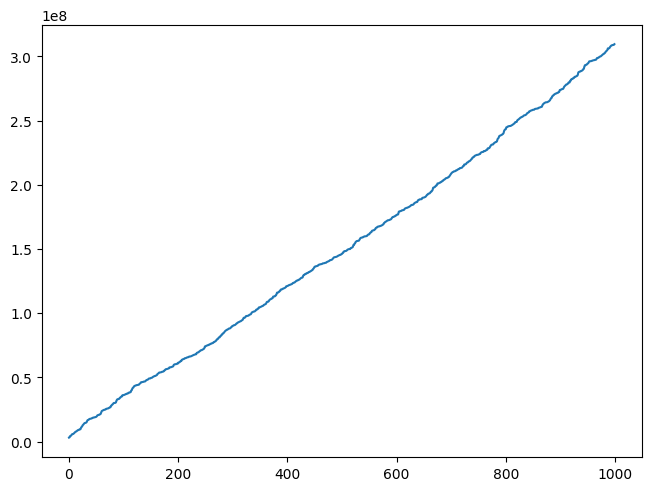

In [949]:
plt.plot(z)

In [912]:
np.std(EGFP.phasor_data[:,1])

0.021096054044991274

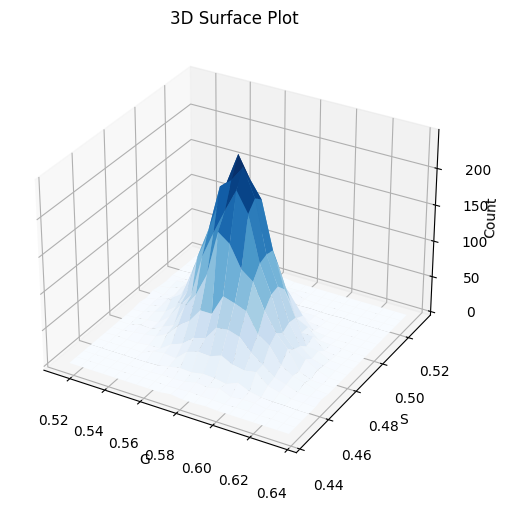

In [911]:
from mpl_toolkits.mplot3d import Axes3D
EGFP.n_photon = [int(1e3),int(1e6),int(1e9)][0]
EGFP.repeat_sim(10000)  
# Create the 2D histogram
hist, x_edges, y_edges = np.histogram2d(EGFP.phasor_data[:,1].real,EGFP.phasor_data[:,1].imag, bins=20)

# Get the bin centers
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2

# Create a meshgrid of the bin centers
X, Y = np.meshgrid(x_centers, y_centers)

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, hist.T, cmap='Blues')

# Set labels and title
ax.set_xlabel('G')
ax.set_ylabel('S')
ax.set_zlabel('Count')
ax.set_title('3D Surface Plot')
ax.tick_params(axis='both', pad=10) 

# Display the plot
plt.show()

In [878]:
np.std(EGFP.phasor_data[:,1].imag)

0.011912507875404417

In [766]:
x_eq(0.5)

0.005062288575523932

In [130]:
result

1.9999999999999933

In [789]:
centre_inv = Point2D(1,0)
alpha= symbols('alpha',real = True)
x = symbols('x0:%d' % (3),real = True)
z = symbols('z0:%d' % (10))
y = symbols('y0:%d' % (3),real = True)
slope = -cot(alpha)
guess = Point2D(x[1],-cot(alpha)*x[1])
p_given = Point2D(x[0],y[0]) #given bi-exp phasor
def harmonic_circ(n):
    '''Returns circle of nth harmonics where different lifetimes lie on
    Input: n -harmonic'''
    return Circle((0.5,-0.5*tan(a)),0.5/cos(a))

def phasor_ray(z,p):
    '''Ray drawn from guess phasor z to given bi-exp phasor p'''
    return Ray((z.real,z.imag),(p.real,p.imag))

def y_intercept_sym(z1,z3,z2):
    '''y-intercept of circle defined by z1,z2,z3,
       z1 lies on y axis (inverted mono exp component)
       z2 = 1
       z3 is the inverted bi exp phasor
       if z1.imag >z3.imag, y-intercept is below z1, hence the np.sign is used
       circle of the form z = (a+bt)/(c+dt) where t is a parameter'''
    a = z2*(z1-z3)
    b = z1*(z2-z3)
    c = z1-z3
    d = z2-z3
    centre = (a*conjugate(d)-b*conjugate(c))/(c*conjugate(d)-d*conjugate(c))
    y_sol = im(z1)-2*im(z2-centre)
    return y_sol

#def y_intercept_slope_sym(z1,z3,alpha):
    '''intercepts of circle with line of slope -cot(alpha), given circle defined by z1,z3,and z2 =1 '''
    #rotate the set up by alpha so the line becomes y intercept
    z2 = np.exp(-alpha*1j)
    z1 *=np.exp(-alpha*1j)
    z3 *=np.exp(-alpha*1j)
    y_sol = y_intercept(z1,z3,z2) #real value only (z4 = y_sol*1j)
    return  np.exp(alpha*1j)*y_sol*1j #rotate back

In [811]:
u = symbols('u1:%d' % (4),real = True)
f = symbols('f',real = True)
mono_sym = lambda n : [(1+u[i])/(1+u[i]*sp.exp(I*alpha*n)) for i in range(0,2)]
bi_sym = lambda n : f*mono_sym(n)[0] +(1-f)*mono_sym(n)[1]

In [812]:
inv(bi_sym(2))

1 + 1/(f*(u1 + 1)/(u1*exp(-2*I*alpha) + 1) + (1 - f)*(u2 + 1)/(u2*exp(-2*I*alpha) + 1) - 1)

In [ ]:
inv(bi_sym)

In [815]:
z3_inv = inv(z[3])
y_intercept_sym((x[1]-x[1]*cot(alpha)*I),inv(bi_sym(1)),1)

-x1*cot(alpha) + 2*((-x1*cot(alpha) - (-f*u1*(u1 + 1)*sin(alpha)/(u1**2*sin(alpha)**2 + (u1*cos(alpha) + 1)**2) - u2*(1 - f)*(u2 + 1)*sin(alpha)/(u2**2*sin(alpha)**2 + (u2*cos(alpha) + 1)**2))/((f*u1*(u1 + 1)*sin(alpha)/(u1**2*sin(alpha)**2 + (u1*cos(alpha) + 1)**2) + u2*(1 - f)*(u2 + 1)*sin(alpha)/(u2**2*sin(alpha)**2 + (u2*cos(alpha) + 1)**2))**2 + (f*(u1 + 1)*(u1*cos(alpha) + 1)/(u1**2*sin(alpha)**2 + (u1*cos(alpha) + 1)**2) + (1 - f)*(u2 + 1)*(u2*cos(alpha) + 1)/(u2**2*sin(alpha)**2 + (u2*cos(alpha) + 1)**2) - 1)**2))*(f*u1*(u1 + 1)*sin(alpha)/(u1**2*sin(alpha)**2 + (u1*cos(alpha) + 1)**2) + u2*(1 - f)*(u2 + 1)*sin(alpha)/(u2**2*sin(alpha)**2 + (u2*cos(alpha) + 1)**2))/((-f*u1*(u1 + 1)*sin(alpha)/(u1**2*sin(alpha)**2 + (u1*cos(alpha) + 1)**2) - u2*(1 - f)*(u2 + 1)*sin(alpha)/(u2**2*sin(alpha)**2 + (u2*cos(alpha) + 1)**2))**2 + (f*(u1 + 1)*(u1*cos(alpha) + 1)/(u1**2*sin(alpha)**2 + (u1*cos(alpha) + 1)**2) + (1 - f)*(u2 + 1)*(u2*cos(alpha) + 1)/(u2**2*sin(alpha)**2 + (u2*cos(alpha) +

In [777]:
Circle(centre_inv,p_given,guess)

Undecidable: 
Cannot determine if Point2D(-y0, x0 - 1) is a scalar multiple of
Point2D(x1/tan(alpha) + y0, -x0 + x1)

In [137]:
a = np.exp(-dt/tau)
def z(n):
    return (1+a)/(1+a*np.exp(1j*n*np.pi/N))
p1 = 0.35+0.16j
p2 = 0.25+0.008j
p = [p1,p2]
def z2(n):
    '''Return z2 for given harmonic'''
    z2 = intersection(harmonic_circ(n),phasor_ray(z(n),p[n-1]))[0].coordinates
    return z2[0]+1j*z2[1]
    

In [138]:
intersection(harmonic_circ(2),phasor_ray(z(2),p[2-1]))[0].coordinates

(12668928146697458581149947214673993512056737/10990916146227808512338131395890000000000000 - 226649235638391*sqrt(23272858502612877813499040969360811714832961960459414278353763641989317233791489)/1152948455874774170327956596802799716575470000000000000,
 -94571119618349517916946188231557916551821707/109909161462278085123381313958900000000000000 + 20787*sqrt(23272858502612877813499040969360811714832961960459414278353763641989317233791489)/109909161462278085123381313958900000000000000)

In [139]:
z2_inv = lambda n : conjugate(1/(z2(n)-1)+1)

In [140]:
def z2_diff(tau):
    '''Return z2_inv(1).real-z2_inv(2).real -> check z2_inv(1) = z2_inv(2)'''
    global a
    a = np.exp(-dt/tau)
    return float(re(z2_inv(1)-z2_inv(2)))

In [148]:
z2_diff(1)

-0.022806951667178155

In [133]:
-0.021410393939246854

-0.0018342873698134643

In [97]:
x = symbols('x')
z_2 = (1+x)/(1+x*exp(1j*2*pi*dt))

In [98]:
from scipy.optimize import root

In [101]:
nsolve(z2_diff,1)

AttributeError: 'function' object has no attribute 'free_symbols'

In [100]:
z(2)

array([1.00000175-0.00805002j])